In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from dataloader import *
from train_eval_test import *
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

2024-01-04 17:41:18.555776: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-04 17:41:20.462623: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 17:41:25.353751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-01-04 17:41:25.356187: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

## Load data

In [2]:
ecl_data = pd.read_csv('data/electricity.csv', header=None).to_numpy()

In [3]:
batch_size = 32
n_train = 18317
n_eval = 2633
n_test = 5261
train_loader, eval_loader, test_loader = get_loaders(ecl_data, batch_size, n_train, n_eval, n_test, T=96, S=96)

## Modèle

In [4]:
class Embedding_inverted(nn.Module):
    def __init__(self, T, D):
        super(Embedding_inverted, self).__init__()
        self.emb = nn.Linear(T, D)
        self.dropout = nn.Dropout(0.1)
    
    def forward(self, x):
        x = x.permute(0,2,1)
        x_emb = self.emb(x)
        return self.dropout(x_emb)

class FeedForward(nn.Module):
    def __init__(self, N):
        super(FeedForward, self).__init__()
        self.feed_forward = nn.Sequential(
          nn.Conv1d(N, N, kernel_size=1),
          nn.GELU(),
          nn.Dropout(0.1),
          nn.Conv1d(N, N, kernel_size=1), 
        )

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.feed_forward(x)
        x = x.permute(0,2,1)
        return x
    
class Attention(nn.Module):
    def __init__(self, N, embed_dim):
        super(Attention, self)
        self.query_projection = nn.Linear(N, N)
        self.key_projection = nn.Linear(N, N)
        self.value_projection = nn.Linear(N, N)

    def forward(self, queries, keys, values):
        B, L, _ = queries.shape
        _, S, _ = keys.shape

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = 1. / torch.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        A = torch.softmax(scale * scores, dim=-1)
        V = torch.einsum("bhls,bshd->blhd", A, values)
        return V
        

class TrmBlock(nn.Module):
    def __init__(self, N,D):
      super(TrmBlock, self).__init__()

      self.multivariate_attention= nn.MultiheadAttention(D, num_heads=1)
      self.layer_norm1 = nn.LayerNorm(D)
      self.feed_forward = FeedForward(D)
      self.layer_norm2 = nn.LayerNorm(D)

    def forward(self, x):
      att,_ = self.multivariate_attention(x,x,x)
      x = self.layer_norm1(x + att)
      #print("x_norm  : ", x.shape)
      #print("permute : ", xT.shape)
      x_forward = self.feed_forward(x)
      x= self.layer_norm2(x + x_forward)
      return x


class iTransformer(nn.Module):
    def __init__(self, N, T, D, S, num_blocks):
      super(iTransformer, self).__init__()

      self.embedding = Embedding_inverted(T, D)
      self.trmblock = nn.ModuleList([TrmBlock(N, D) for _ in range(num_blocks)])
      self.projection = nn.Linear(D, S, bias=True)


    def forward(self, x):
      #print("x : ",x.shape)
      x = self.embedding(x)
      #print('emb : ',x.shape)
      for block in self.trmblock:
            x = block(x)
      #print('trmblock : ',x.shape)
      y = self.projection(x)
      #print('proj : ', y.shape)
      y=y.permute(0,2,1)
      #print('final : ', y.shape)
      return y

## Train

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
writer = SummaryWriter()

cuda


In [6]:
N = 321 #nb variables
T = 96 #input length (lookback window)
D = 256 # ou 512
S = 96 # ou 192, 336, 720
#hidden_dim = 176 #dimension latente dans le feed forward du transformer 
num_blocks = 4 #2 ou 3 ou 4 (nombre de block de transformer)

itransformer = iTransformer(N, T, D, S, num_blocks).to(device)
optimizer = torch.optim.Adam(itransformer.parameters(), lr=1e-3) #10−3, 5 × 10−4, 10−4 



In [7]:
loss_values, loss_eval = train(itransformer, optimizer, train_loader, eval_loader, 10, device, writer)

---- epoch :  0
loss train : 0.20902933558774373
loss eval : 0.1558529773315826
---- epoch :  1
loss train : 0.17619793038204234
loss eval : 0.1510655138786737
---- epoch :  2
loss train : 0.16857255708813879
loss eval : 0.1521186718305984
---- epoch :  3
loss train : 0.16474114834105946
loss eval : 0.1441758144404981
---- epoch :  4
loss train : 0.16145097715303802
loss eval : 0.1434505626365736
---- epoch :  5
loss train : 0.15937478632733515
loss eval : 0.14415293883580665
---- epoch :  6
loss train : 0.15652050180409952
loss eval : 0.14076299491253766
---- epoch :  7
loss train : 0.15538870644422226
loss eval : 0.14060409144534694
---- epoch :  8
loss train : 0.1538572213374328
loss eval : 0.1425057990210397
---- epoch :  9
loss train : 0.15280395257409918
loss eval : 0.14152395899419662


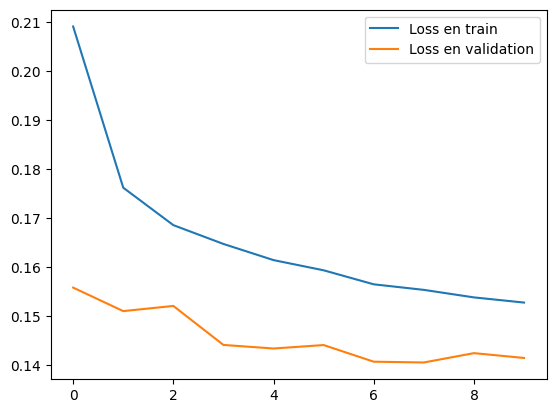

In [8]:
plt.figure()
plt.plot(loss_values,label="Loss en train")
plt.plot(loss_eval,label="Loss en validation")
plt.legend()
plt.show()

## Test

In [10]:
loss_test, target, yhat = test(itransformer, test_loader, device)
print("MSE : ", loss_test)

MSE :  0.17998646304775506


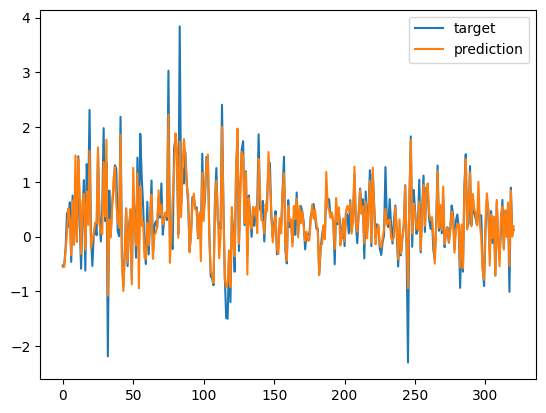

In [11]:
plt.figure()
plt.plot(target[0][:][0].to("cpu"),label="target")
plt.plot(yhat[0][:][0].to("cpu"),label="prediction")
plt.legend()
plt.show()


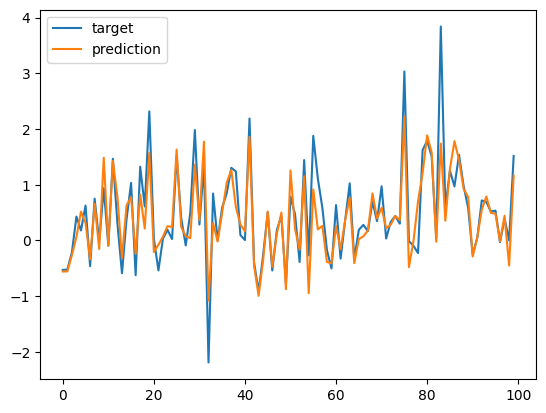

In [12]:
plt.figure()
plt.plot(target[0][:][0][:100].to("cpu"),label="target")
plt.plot(yhat[0][:][0][:100].to("cpu"),label="prediction")
plt.legend()
plt.show()